Load data

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from scipy.stats import entropy


def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

chargingprofile1 = pd.read_csv('./data/yearly_charging_profile_1.csv', header=None)
chargingprofile1 = chargingprofile1.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile1.index = range(1, len(chargingprofile1) + 1)
chargingprofile1 = min_max_normalize(chargingprofile1)

consumer1 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad861.csv', header=None)
consumer1 = consumer1
consumer1.columns = range(1, consumer1.shape[1] + 1)
consumer1.index = range(1, len(consumer1) + 1)

consumer2 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad464.csv', header=None)
consumer2 = consumer2
consumer2.columns = range(1, consumer2.shape[1] + 1)
consumer2.index = range(1, len(consumer2) + 1)

consumer3 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad540.csv', header=None)
consumer3 = consumer3
consumer3.columns = range(1, consumer3.shape[1] + 1)
consumer3.index = range(1, len(consumer3) + 1)

solargen = pd.read_excel('./data/Belgium_solar_generation_probability_density.xlsx', sheet_name='Solar_profiles',header=None)
solargen = solargen
solargen = solargen.drop(index=0, columns=0).reset_index(drop=True)
solargen.index = range(1, len(solargen) + 1)
solargen = solargen.iloc[:, :-1]

In [228]:
def load_all_consumers():
    all_consumers = []
    directory = './data/Fluvius load profiles type 1 consumer/'
    for filename in os.listdir(directory):        
        consumer = pd.read_csv(directory+filename, header=None)
        consumer.columns = range(1, consumer1.shape[1] + 1)
        consumer.index = range(1, len(consumer1) + 1)
        #all_consumers = pd.concat([all_consumers, consumer], axis=1)
        all_consumers.append(consumer)
    return all_consumers
all_consumers = load_all_consumers()


In [229]:
def sum_columns(df):
    # Sum the values of each column and return as a Series
    return df.sum()

Heatmap of EV+PV per consumer

In [230]:
kwp_set = np.arange(0, 10, 0.5)
kw_set = np.arange(0, 23, 0.5)
nb_kwp = len(kwp_set)
nb_kw = len(kw_set)

matrix_min = np.zeros((nb_kwp, nb_kw))
matrix_max = np.zeros((nb_kwp, nb_kw))
matrix_mean = np.zeros((nb_kwp, nb_kw))
matrix_std = np.zeros((nb_kwp, nb_kw))
matrix_skew = np.zeros((nb_kwp, nb_kw))
matrix_kurt = np.zeros((nb_kwp, nb_kw))
matrix_load = np.zeros((nb_kwp, nb_kw))
matrix_q5 = np.zeros((nb_kwp, nb_kw))
matrix_q95 = np.zeros((nb_kwp, nb_kw))

for kwp in range(nb_kwp):
    for kw in range(nb_kw):
        net_load = consumer1*4 - kwp_set[kwp]*solargen + kw_set[kw]*chargingprofile1
        net_load = net_load/4
        net_load = sum_columns(net_load)
        
        matrix_min[kwp,kw] = net_load.values.flatten().min()
        matrix_max[kwp,kw] = net_load.values.flatten().max()
        matrix_mean[kwp,kw] = net_load.values.flatten().mean()
        matrix_std[kwp,kw] = net_load.values.flatten().std()
        matrix_skew[kwp,kw] = pd.Series(net_load.values.flatten()).skew()
        matrix_kurt[kwp,kw] = pd.Series(net_load.values.flatten()).kurt()
        matrix_load[kwp,kw] = net_load.sum().sum()
        matrix_q5[kwp,kw] = pd.Series(net_load.values.flatten()).quantile(.05)
        matrix_q95[kwp,kw] = pd.Series(net_load.values.flatten()).quantile(.95)

In [231]:
def plot_multiple_heatmaps(matrix_list, moments, cols=2):

    num_heatmaps = len(matrix_list)
    rows = -(-num_heatmaps // cols)  
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))
    axes = axes.flatten()  

    for i, (matrix, moment) in enumerate(zip(matrix_list, moments)):
        ax = axes[i]
        matrix = matrix[::-1]  # Reverse the matrix rows
        y_labels = list(map(str, kwp_set))
        y_labels.reverse()
        x_labels = list(map(str, kw_set))

        sns.heatmap(
            matrix, annot=False, cmap='coolwarm', cbar=True, 
            xticklabels=x_labels, yticklabels=y_labels, 
            ax=ax, annot_kws={"size": 12}
        )

        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)

        title = (
            f'{moment} [kWh]' if moment in [
                "Mean", "Standard deviation", "Minimum", "Maximum", 
                "Total energy consumed", "0,05 quantile", "0,95 quantile"
            ] else moment
        )
        ax.set_title(title, fontsize=18, weight='bold')
        ax.set_ylabel("PV: kWp values", fontsize=14)
        ax.set_xlabel("EV: charger kW values", fontsize=14)
        tick_interval =5
        ax.set_xticks(ax.get_xticks()[::tick_interval])
        ax.set_yticks(ax.get_yticks()[::tick_interval])

    for i in range(len(matrix_list), len(axes)):
        axes[i].axis('off')

    plt.tight_layout() 
    plt.show()

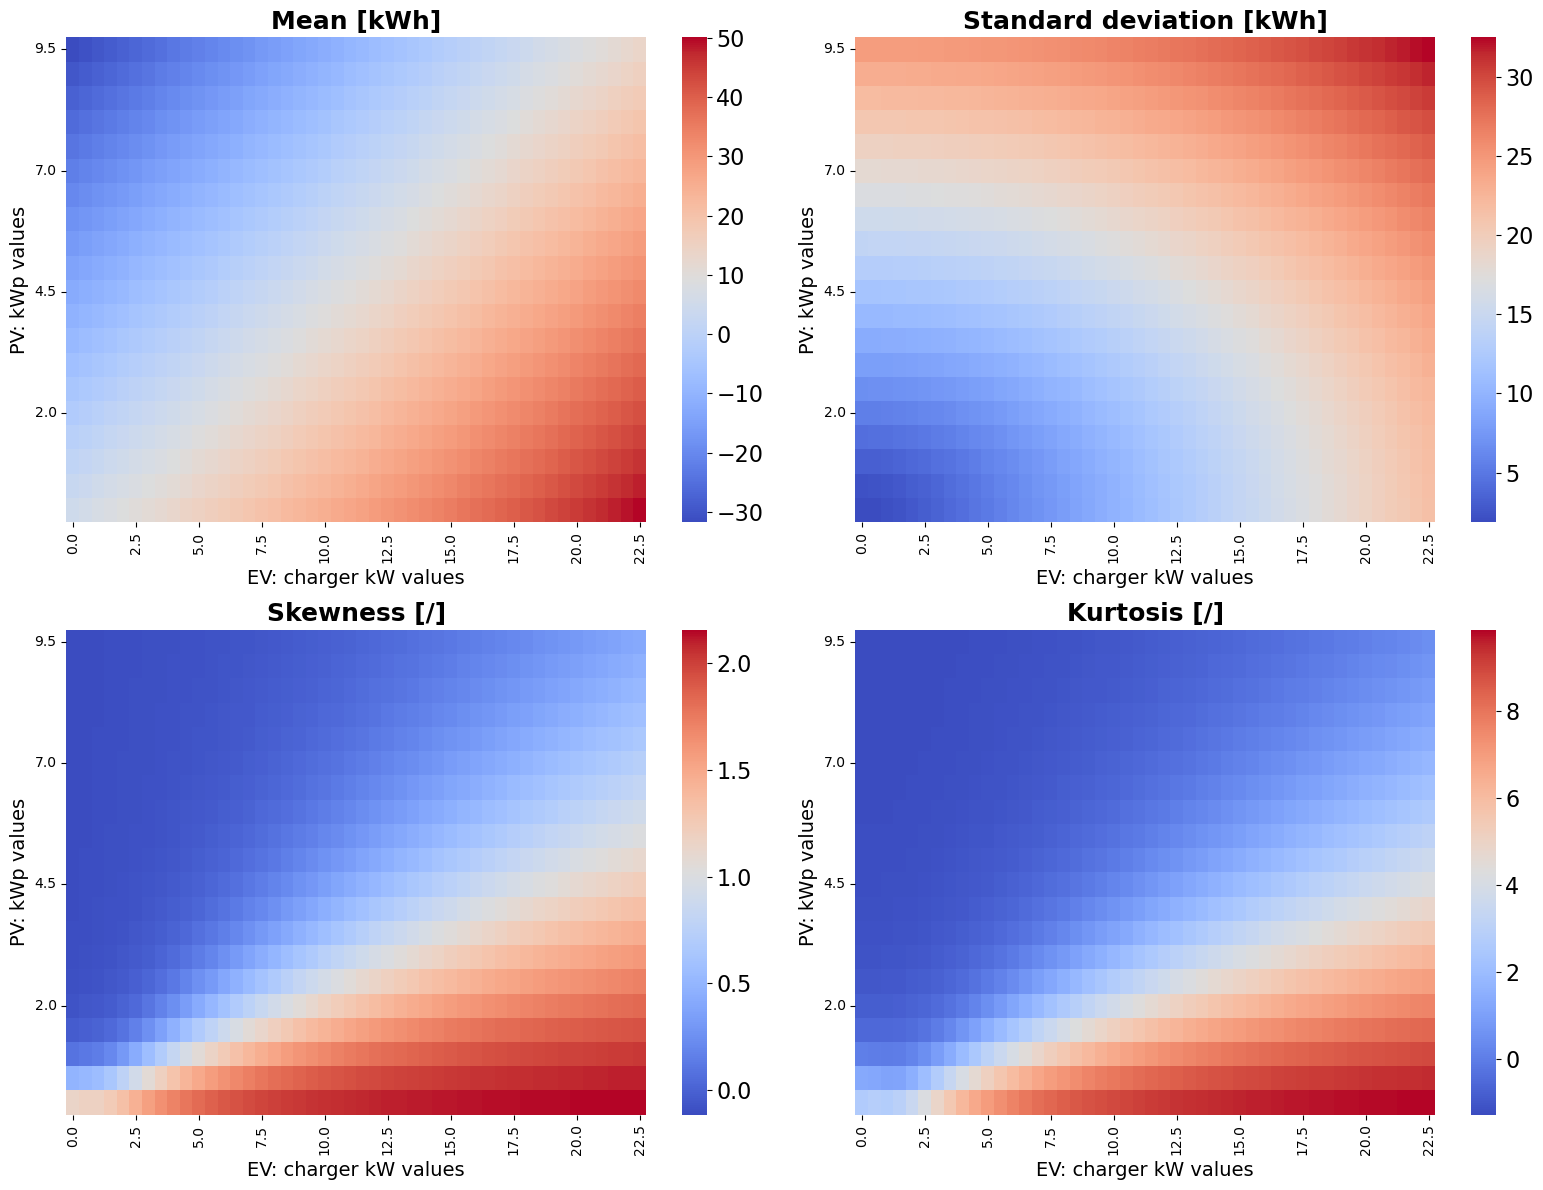

In [232]:
plot_multiple_heatmaps([matrix_mean, matrix_std, matrix_skew, matrix_kurt], ["Mean [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)

Evolution of metrics with PV seperatly

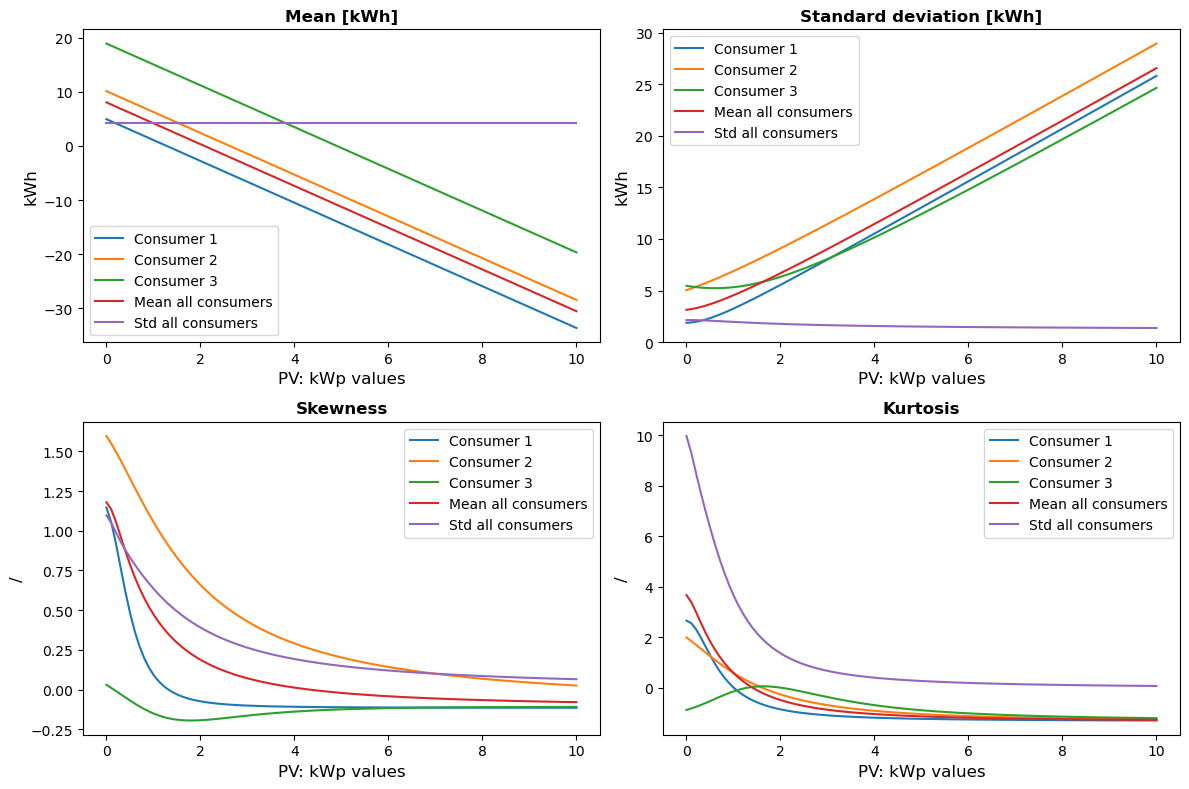

In [233]:
kwp_set = np.linspace(0, 10, 100)

def metrics_M_PV(consumer,kwp_set,solargen):
    mean_pv = []
    std_pv = []
    skew_pv = []
    kurt_pv = []
    cov = []
    for kwp in kwp_set:
        multiplier = int(len(consumer.columns)/365)
        solargen_adapted = pd.concat([solargen]*multiplier, axis=1)
        net_load = consumer-((kwp*solargen_adapted)/4)
        net_load = sum_columns(net_load)
        mean_pv.append(net_load.mean())
        std_pv.append(net_load.std())
        skew_pv.append(net_load.skew())
        kurt_pv.append(net_load.kurt())
        cov.append(net_load.std()/net_load.mean())
    return mean_pv, std_pv, skew_pv, kurt_pv

def mean_metrics_all_consumers(all_consumers,kwp_set,solargen):
    mean_all_consumers = pd.DataFrame()
    std_all_consumers = pd.DataFrame()
    skew_all_consumers = pd.DataFrame()
    kurt_all_consumers = pd.DataFrame()

    for consumer in all_consumers:
        mean = []
        std = []
        skew = []
        kurt = []
        for kwp in kwp_set:
            net_load = consumer-((kwp*solargen)/4)
            net_load = sum_columns(net_load)
            mean.append(net_load.mean())
            std.append(net_load.std())
            skew.append(net_load.skew())
            kurt.append(net_load.kurt())
        mean_all_consumers = pd.concat([mean_all_consumers, pd.DataFrame([mean])])
        std_all_consumers = pd.concat([std_all_consumers, pd.DataFrame([std])])
        skew_all_consumers = pd.concat([skew_all_consumers, pd.DataFrame([skew])])
        kurt_all_consumers = pd.concat([kurt_all_consumers, pd.DataFrame([kurt])])

    return [mean_all_consumers.mean(), std_all_consumers.mean(), skew_all_consumers.mean(), kurt_all_consumers.mean()], [mean_all_consumers.std(), std_all_consumers.std(), skew_all_consumers.std(), kurt_all_consumers.std()]
        
metrics_consumer1 = metrics_M_PV(consumer1, kwp_set, solargen)
metrics_consumer2 = metrics_M_PV(consumer2, kwp_set, solargen)
metrics_consumer3 = metrics_M_PV(consumer3, kwp_set, solargen)
metrics_all_consumers = mean_metrics_all_consumers(all_consumers,kwp_set,solargen)


### Plot
metrics = [0, 1, 2, 3]
titles = ['Mean [kWh]', 'Standard deviation [kWh]', 'Skewness', 'Kurtosis']  # Titles for each plot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    metric = metrics[i]
    ax.set_title(titles[i], fontsize=12, weight='bold')
    ax.set_xlabel("PV: kWp values", fontsize=12)
    y_text = "kWh" if metrics[i] in [0, 1] else "/"
    ax.set_ylabel(y_text, fontsize=12)

    ax.plot(kwp_set, metrics_consumer1[metric], label='Consumer 1')
    ax.plot(kwp_set, metrics_consumer2[metric], label='Consumer 2')
    ax.plot(kwp_set, metrics_consumer3[metric], label='Consumer 3')
    ax.plot(kwp_set, metrics_all_consumers[0][metric], label='Mean all consumers')
    ax.plot(kwp_set, metrics_all_consumers[1][metric], label='Std all consumers')
    ax.legend() 

plt.tight_layout()
plt.show()


<Axes: ylabel='Density'>

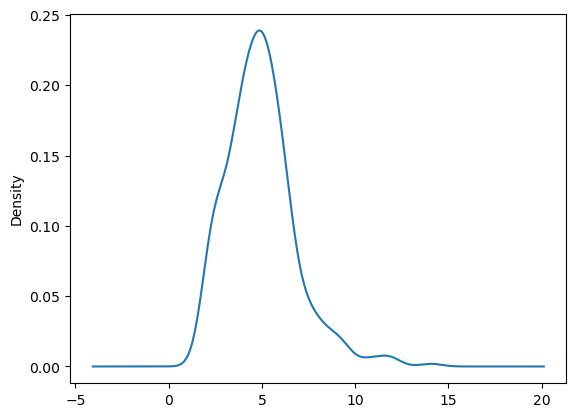

In [238]:
sum_columns(consumer1).plot.density()
# sum_columns(consumer2).plot.density()
# sum_columns(consumer3).plot.density()
# all_consumers = load_all_consumers()
# df = pd.concat(all_consumers,axis=1)
# sum_columns(df).plot.density()

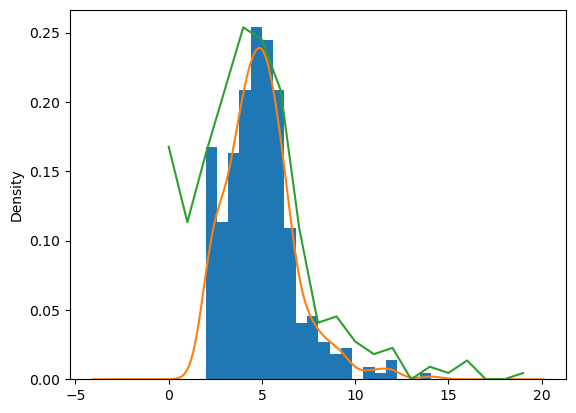

In [235]:
data = sum_columns(consumer1)
bins = 20
plt.hist(data,bins=bins,density=True)
#plt.plot(sum_columns(consumer1))
sum_columns(consumer1).plot.density()

hist, bin_edges = np.histogram(data, bins=bins, density=True)
probabilities = hist / np.sum(hist)
plt.plot(hist)

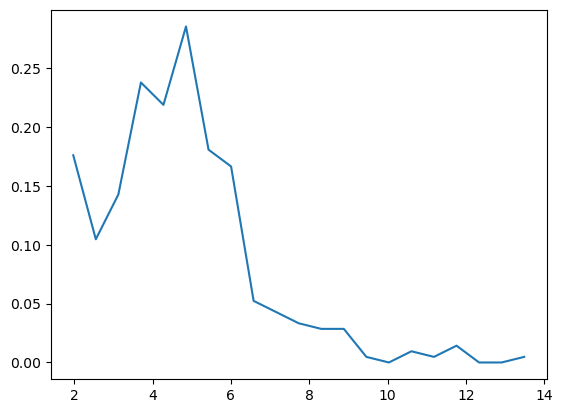

In [236]:
hist, bin_edges = np.histogram(sum_columns(consumer1), bins='auto', density=True)
plt.plot(bin_edges[:-1], hist)

Evolution of metrics with EV seperatly

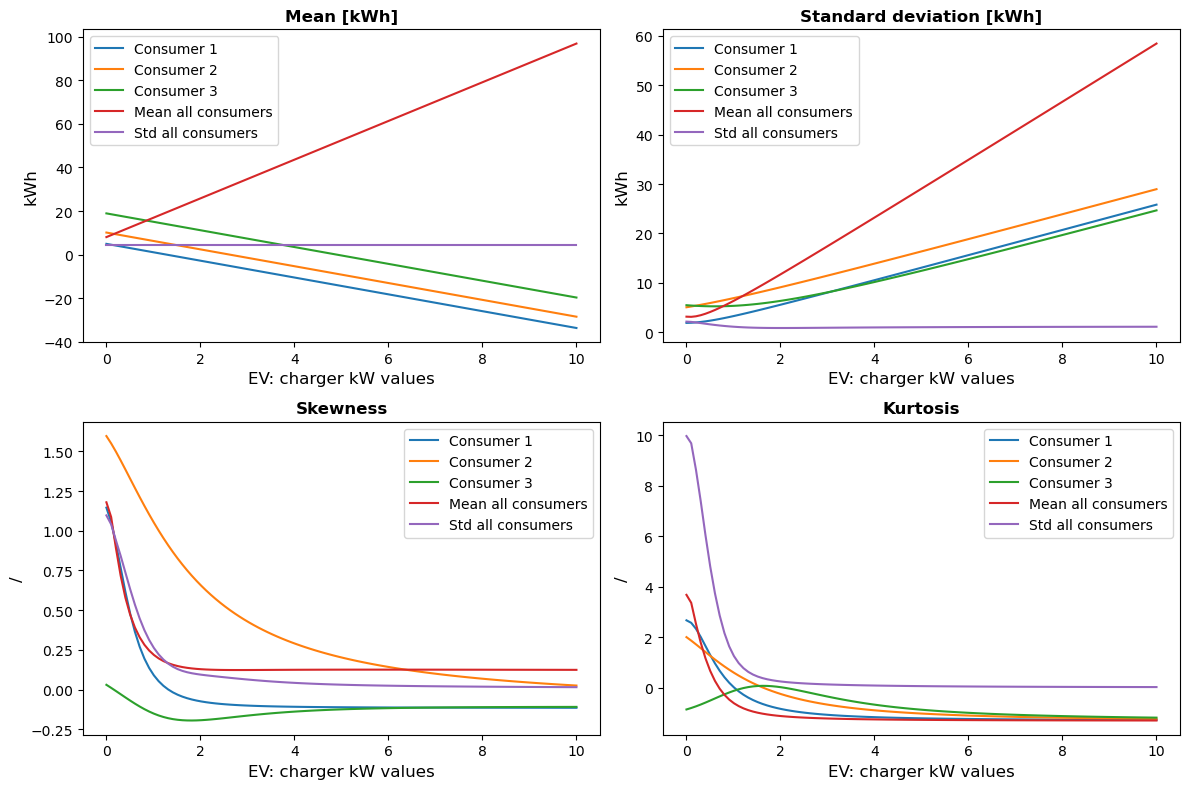

In [ ]:
kw_set = np.linspace(0, 23, 100)

def metrics_M_EV(consumer, chargingprofile, kw_set):
    total_load = []
    min_pv = []
    max_pv = []
    q05 = []
    q95 = []
    mean_pv = []
    std_pv = []
    skew_pv = []
    kurt_pv = []
    for kw in kw_set:
        net_load = consumer+((kw*chargingprofile)/4)
        net_load = sum_columns(net_load)
        total_load.append(net_load.sum())
        min_pv.append(net_load.min())
        max_pv.append(net_load.max())
        q05.append(net_load.quantile(.05))
        q95.append(net_load.quantile(.95))
        mean_pv.append(net_load.mean())
        std_pv.append(net_load.std())
        skew_pv.append(net_load.skew())
        kurt_pv.append(net_load.kurt())
    return min_pv, max_pv, total_load, q05, q95, mean_pv, std_pv, skew_pv, kurt_pv

def mean_metrics_all_consumers(all_consumers,kw_set,chargingprofile):
    mean_all_consumers = pd.DataFrame()
    std_all_consumers = pd.DataFrame()
    skew_all_consumers = pd.DataFrame()
    kurt_all_consumers = pd.DataFrame()

    for consumer in all_consumers:
        mean = []
        std = []
        skew = []
        kurt = []
        for kw in kw_set:
            net_load = consumer+((kw*chargingprofile)/4)
            net_load = sum_columns(net_load)
            mean.append(net_load.mean())
            std.append(net_load.std())
            skew.append(net_load.skew())
            kurt.append(net_load.kurt())
        mean_all_consumers = pd.concat([mean_all_consumers, pd.DataFrame([mean])])
        std_all_consumers = pd.concat([std_all_consumers, pd.DataFrame([std])])
        skew_all_consumers = pd.concat([skew_all_consumers, pd.DataFrame([skew])])
        kurt_all_consumers = pd.concat([kurt_all_consumers, pd.DataFrame([kurt])])

    return [mean_all_consumers.mean(), std_all_consumers.mean(), skew_all_consumers.mean(), kurt_all_consumers.mean()], [mean_all_consumers.std(), std_all_consumers.std(), skew_all_consumers.std(), kurt_all_consumers.std()]

metrics_consumer1 = metrics_M_PV(consumer1, kw_set, solargen)
metrics_consumer2 = metrics_M_PV(consumer2, kw_set, solargen)
metrics_consumer3 = metrics_M_PV(consumer3, kw_set, solargen)
metrics_all_consumers = mean_metrics_all_consumers(all_consumers,kw_set,solargen)

### Plot
metrics = [0, 1, 2, 3]
titles = ['Mean [kWh]', 'Standard deviation [kWh]', 'Skewness', 'Kurtosis']  # Titles for each plot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    metric = metrics[i]
    ax.set_title(titles[i], fontsize=12, weight='bold')
    ax.set_xlabel("EV: charger kW values", fontsize=12)
    y_text = "kWh" if metrics[i] in [0, 1] else "/"
    ax.set_ylabel(y_text, fontsize=12)

    ax.plot(kw_set, metrics_consumer1[metric], label='Consumer 1')
    ax.plot(kw_set, metrics_consumer2[metric], label='Consumer 2')
    ax.plot(kw_set, metrics_consumer3[metric], label='Consumer 3')
    ax.plot(kw_set, metrics_all_consumers[0][metric], label='Mean all consumers')
    ax.plot(kw_set, metrics_all_consumers[1][metric], label='Std all consumers')
    ax.legend() 

plt.tight_layout()
plt.show()

       